In [1]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mypath = "./Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [3]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file) 

In [4]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [5]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [6]:
p_diag = pd.read_csv("./Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file

In [7]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [8]:
features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

Finished feature extraction from  920  files


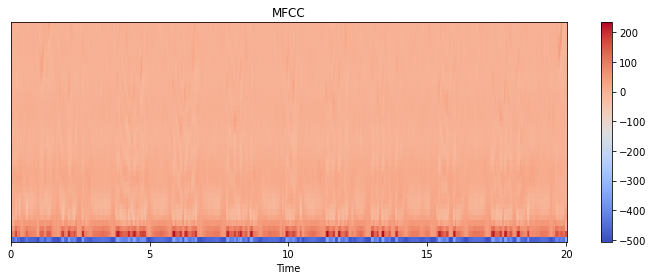

In [9]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[5], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [10]:
features = np.array(features) # convert to numpy array

In [16]:
features.shape

(920, 40, 862)

In [134]:
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [12]:
# print class counts
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


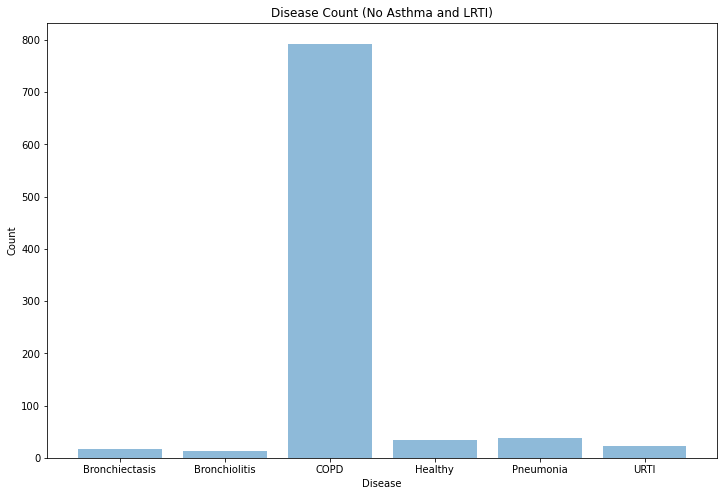

In [13]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count (No Asthma and LRTI)')
plt.show()

In [14]:
from tensorflow.keras.utils import to_categorical
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels) 

## Pytorch implementation

This CNN network is the same as Tensorflow implementation found on Kaggle. Number of epochs for training is 50 instead of 100 because there is not much improvement after the first 50 epochs. 

Further improvements to this problem would be:
- trying different network architectures
- **data augmentation** for classes that have little data
- more focus on ther metrics such as f1 score rather than accuracy

In [15]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch

In [79]:
filter_size = 3
num_labels = oh_labels.shape[1]

class ConvNet(Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = Sequential(
            Conv2d(1, 16, kernel_size=2, stride=1, padding=0),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=0),
            Dropout(0.2, inplace=True))
        
        self.layer2 = Sequential(
            Conv2d(16, 32, kernel_size=2, stride=1, padding=0),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=0),
            Dropout(0.2, inplace=True))
        
        self.layer3 = Sequential(
            Conv2d(32, 64, kernel_size=2, stride=1, padding=0),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=0),
            Dropout(0.2, inplace=True))
        
        self.layer4 = Sequential(
            Conv2d(64, 128, kernel_size=2,stride=1, padding=0),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=0),
            Dropout(0.2, inplace=True))

        self.fc2 = Linear(128, num_labels)
        self.softmax = Softmax()
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.mean([2, 3])
        out = torch.flatten(out,1)
        out = self.fc2(out)
        return out

In [80]:
model = ConvNet()

optimizer = Adam(model.parameters(), lr=0.001)
# optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = CrossEntropyLoss()
# checking if GPU is available
# if torch.cuda.is_available():
#     print('GPU is avaliable')
#     model = model.cuda()
#     criterion = criterion.cuda()
    
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=True)
  )
  (fc2): Linear(in_features=128, out_features=6, bias=True)
  (softmax): Softmax(dim=None)


In [82]:
def convert_data(x, y, kind='train'):
    x = x.reshape(x.shape[0], 1, 40, 862)
    x  = torch.from_numpy(x)

    y = y.astype(int);
    y = torch.from_numpy(y)
    
    dataset = TensorDataset(x, y)
    loader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=32)
    return loader

In [83]:
from torch.utils.data import TensorDataset
from torch import Tensor

train_x, test_x, train_y, test_y = train_test_split(features1, i_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)

trainloader = convert_data(train_x, train_y, 'train')
valloader = convert_data(val_x, val_y, 'val')

In [84]:
dataloaders = {'train': trainloader, 'val': valloader}

In [85]:
import copy
import time

def train_model(model, dataloaders, criterion, optimizer, num_epochs=50):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                labels = labels.type(torch.LongTensor)
                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

In [86]:
best_model,val_acc, train_acc, val_loss, train_loss = train_model(model, dataloaders, criterion, optimizer)

Epoch 0/49
----------
train Loss: 1.5578 Acc: 0.7876
val Loss: 0.9048 Acc: 0.9054

Epoch 1/49
----------
train Loss: 0.7663 Acc: 0.8604
val Loss: 1.0112 Acc: 0.9054

Epoch 2/49
----------
train Loss: 0.6110 Acc: 0.8604
val Loss: 0.8827 Acc: 0.8784

Epoch 3/49
----------
train Loss: 0.5463 Acc: 0.8574
val Loss: 0.6714 Acc: 0.8649

Epoch 4/49
----------
train Loss: 0.4827 Acc: 0.8528
val Loss: 0.4559 Acc: 0.8784

Epoch 5/49
----------
train Loss: 0.4446 Acc: 0.8619
val Loss: 0.3766 Acc: 0.8919

Epoch 6/49
----------
train Loss: 0.4245 Acc: 0.8695
val Loss: 0.3532 Acc: 0.9054

Epoch 7/49
----------
train Loss: 0.4015 Acc: 0.8741
val Loss: 0.3267 Acc: 0.8919

Epoch 8/49
----------
train Loss: 0.3908 Acc: 0.8649
val Loss: 0.3254 Acc: 0.8919

Epoch 9/49
----------
train Loss: 0.3714 Acc: 0.8725
val Loss: 0.3094 Acc: 0.8919

Epoch 10/49
----------
train Loss: 0.3692 Acc: 0.8741
val Loss: 0.2999 Acc: 0.8919

Epoch 11/49
----------
train Loss: 0.3618 Acc: 0.8756
val Loss: 0.3009 Acc: 0.9054

Ep

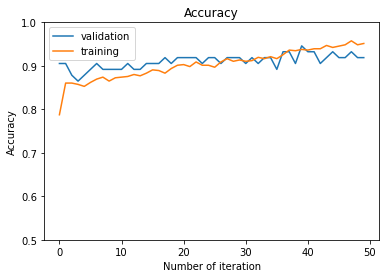

In [87]:
from matplotlib import pyplot as plt 
%matplotlib inline
 
fig = plt.figure()
plt.plot(val_acc)
plt.plot(train_acc)
plt.ylim([0.5,1])
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.legend(['validation', 'training'])
plt.title('Accuracy')
plt.show()

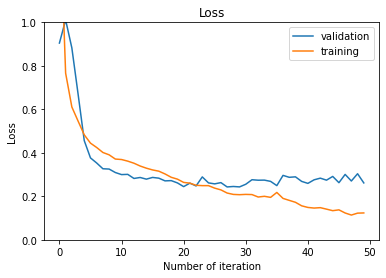

In [88]:
fig = plt.figure()
plt.plot(val_loss)
plt.plot(train_loss)
plt.ylim([0,1])
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.legend(['validation', 'training'])
plt.title('Loss')
plt.show()

In [89]:
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
class_predicted = list(0. for i in range(6))
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    test_x = test_x.reshape(test_x.shape[0], 1, 40, 862)
    test_x = torch.from_numpy(test_x)

    test_y = test_y.astype(int)
    test_y = torch.from_numpy(test_y)
    test_y = test_y.type(torch.LongTensor)
#         if torch.cuda.is_available():
#             images = images.cuda()
#             labels = labels.cuda()
    outputs = model(test_x)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == test_y).squeeze()
    total += test_y.size(0)
    correct += (predicted == test_y).sum().item()
    print('Test Accuracy of the model on test images: {} %'.format((correct / total) * 100))
    for i in predicted:
        class_predicted[i] += 1
    for i in range(len(test_y)):
        label = test_y[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

Test Accuracy of the model on test images: 88.58695652173914 %


In [90]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print(accuracy_score(test_y, predicted))
print(f1_score(test_y, predicted, average='macro'))

0.8858695652173914
0.45703284468361477


In [170]:
import seaborn as sn

def conf_matrix(y_true, y_pred):
    data = {'Actual':    y_true,
        'Predicted': y_pred
        }
    df = pd.DataFrame(data, columns=['Actual','Predicted'])
    confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

    sn.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt='g')
    plt.show()

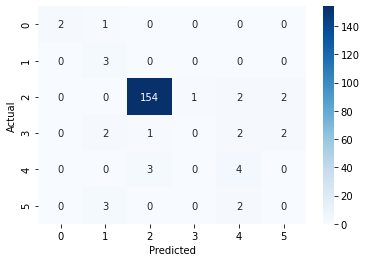

In [171]:
conf_matrix(test_y, predicted)

In [116]:
test_y_oh = to_categorical(test_y) 
predicted_oh = to_categorical(predicted)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y_oh[:, i], predicted_oh[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

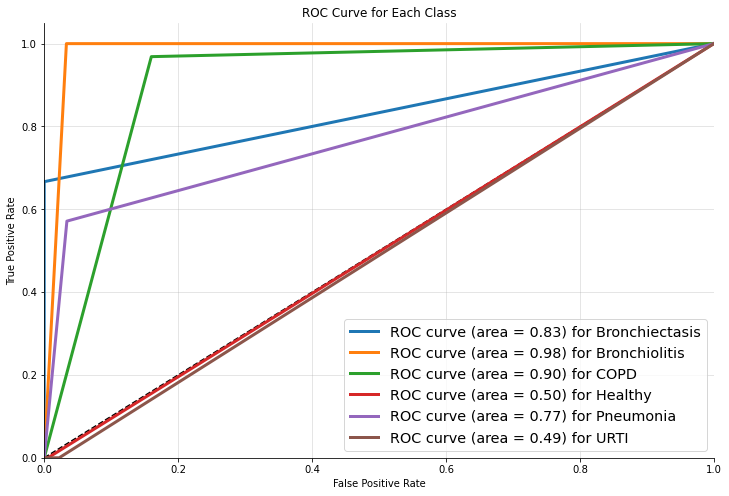

In [119]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

## Tensorflow implementation

In [148]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

num_rows = 40
num_columns = 862
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [149]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [150]:
# Display model architecture summary 
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 19, 430, 16)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 213, 64)       

In [151]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

c:\users\asus\anaconda3\envs\task1\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


**Training**

In [139]:
features1 = np.reshape(features1, (*features1.shape,1)) 

In [152]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, 
                                                    test_size=0.1, random_state = 42)

In [153]:
# train model
num_epochs = 100
num_batch_size = 64

# callbacks = [
#     ModelCheckpoint(
#         filepath='mymodel2_{epoch:02d}.h5',
#         save_best_only=True,
#         monitor='val_accuracy',
#         verbose=1)
# ]
callback = EarlyStopping(monitor='val_loss',  mode='min', patience=3)

start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_val, y_val), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 659 samples, validate on 74 samples
Epoch 1/100
640/659 [============================>.] - ETA: 0s - loss: 5.2222 - accuracy: 0.7234
Epoch 00001: val_accuracy did not improve from 0.90541
659/659 [==============================] - 7s 11ms/sample - loss: 5.2079 - accuracy: 0.7253 - val_loss: 1.7894 - val_accuracy: 0.7162
Epoch 2/100
640/659 [============================>.] - ETA: 0s - loss: 2.6746 - accuracy: 0.7875
Epoch 00002: val_accuracy did not improve from 0.90541
659/659 [==============================] - 7s 10ms/sample - loss: 2.6529 - accuracy: 0.7815 - val_loss: 1.3112 - val_accuracy: 0.7432
Epoch 3/100
640/659 [============================>.] - ETA: 0s - loss: 1.6147 - accuracy: 0.8219
Epoch 00003: val_accuracy did not improve from 0.90541
659/659 [==============================] - 10s 15ms/sample - loss: 1.5996 - accuracy: 0.8225 - val_loss: 0.8002 - val_accuracy: 0.8378
Epoch 4/100
640/659 [============================>.] - ETA: 0s - loss: 1.0811 - accuracy: 0.8344

Epoch 30/100
640/659 [============================>.] - ETA: 0s - loss: 0.3312 - accuracy: 0.8781
Epoch 00030: val_accuracy did not improve from 0.90541
659/659 [==============================] - 8s 13ms/sample - loss: 0.3333 - accuracy: 0.8771 - val_loss: 0.4650 - val_accuracy: 0.8514
Epoch 31/100
640/659 [============================>.] - ETA: 0s - loss: 0.3526 - accuracy: 0.8891
Epoch 00031: val_accuracy did not improve from 0.90541
659/659 [==============================] - 8s 13ms/sample - loss: 0.3487 - accuracy: 0.8892 - val_loss: 0.4463 - val_accuracy: 0.8514
Epoch 32/100
640/659 [============================>.] - ETA: 0s - loss: 0.4032 - accuracy: 0.8562
Epoch 00032: val_accuracy did not improve from 0.90541
659/659 [==============================] - 8s 13ms/sample - loss: 0.3959 - accuracy: 0.8604 - val_loss: 0.4212 - val_accuracy: 0.8649
Epoch 33/100
640/659 [============================>.] - ETA: 0s - loss: 0.3551 - accuracy: 0.8719
Epoch 00033: val_accuracy did not improve

Epoch 59/100
640/659 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9062
Epoch 00059: val_accuracy did not improve from 0.90541
659/659 [==============================] - 9s 13ms/sample - loss: 0.2267 - accuracy: 0.9044 - val_loss: 0.3443 - val_accuracy: 0.8784
Epoch 60/100
640/659 [============================>.] - ETA: 0s - loss: 0.2254 - accuracy: 0.9141
Epoch 00060: val_accuracy did not improve from 0.90541
659/659 [==============================] - 9s 14ms/sample - loss: 0.2261 - accuracy: 0.9135 - val_loss: 0.3383 - val_accuracy: 0.9054
Epoch 61/100
640/659 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9094
Epoch 00061: val_accuracy did not improve from 0.90541
659/659 [==============================] - 9s 13ms/sample - loss: 0.2384 - accuracy: 0.9105 - val_loss: 0.3330 - val_accuracy: 0.8784
Epoch 62/100
640/659 [============================>.] - ETA: 0s - loss: 0.2202 - accuracy: 0.9266
Epoch 00062: val_accuracy did not improve

Epoch 88/100
640/659 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9094
Epoch 00088: val_accuracy did not improve from 0.90541
659/659 [==============================] - 8s 12ms/sample - loss: 0.2204 - accuracy: 0.9120 - val_loss: 0.3833 - val_accuracy: 0.8919
Epoch 89/100
640/659 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9141
Epoch 00089: val_accuracy did not improve from 0.90541
659/659 [==============================] - 8s 12ms/sample - loss: 0.2250 - accuracy: 0.9120 - val_loss: 0.4405 - val_accuracy: 0.9054
Epoch 90/100
640/659 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy: 0.9297
Epoch 00090: val_accuracy did not improve from 0.90541
659/659 [==============================] - 9s 13ms/sample - loss: 0.1773 - accuracy: 0.9302 - val_loss: 0.4034 - val_accuracy: 0.8784
Epoch 91/100
640/659 [============================>.] - ETA: 0s - loss: 0.1884 - accuracy: 0.9203
Epoch 00091: val_accuracy did not improve

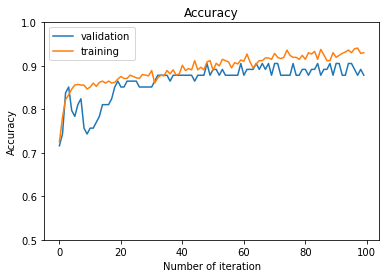

In [154]:
fig = plt.figure()
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.ylim([0.5,1])
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.legend(['validation', 'training'])
plt.title('Accuracy')
plt.show()

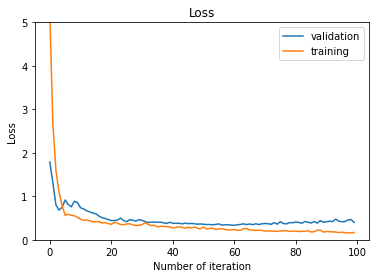

In [155]:
fig = plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.ylim([0,5])
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.legend(['validation', 'training'])
plt.title('Loss')
plt.show()

**Evaluating the model on the training and testing set**

In [156]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
y_pred = model.predict(x_test)
print("Testing Accuracy: ", score[1])
# print("Testing f1 score: ", f1_score(y_pred, y_test, average='macro'))

Training Accuracy:  0.9150228
Testing Accuracy:  0.86413044


In [157]:
preds = model.predict(x_test) 
classpreds = np.argmax(preds, axis=1) 
y_testclass = np.argmax(y_test, axis=1)
n_classes=6

In [158]:
print("Testing f1 score: ", f1_score(classpreds, y_testclass, average='macro'))

Testing f1 score:  0.36723908100054886


In [159]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [160]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

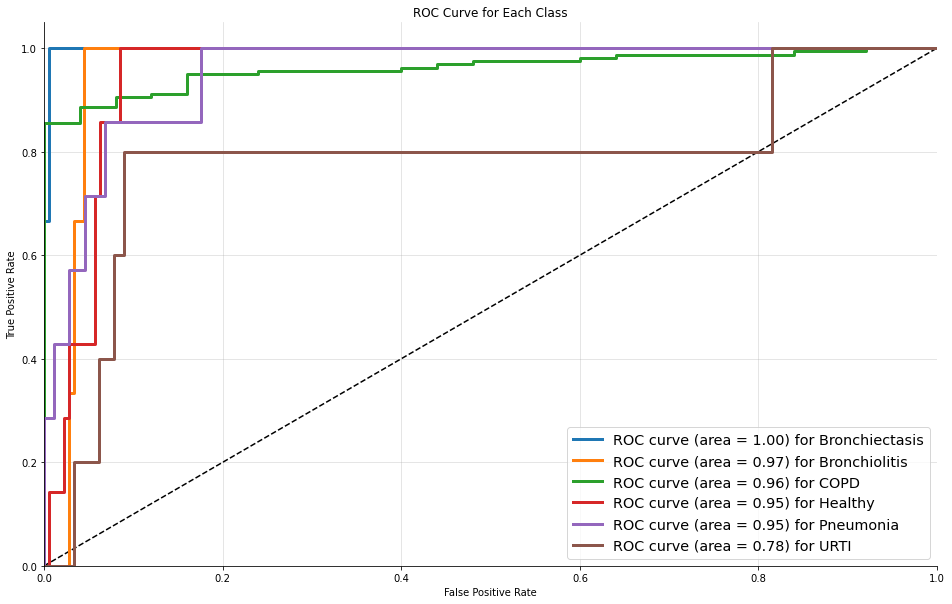

In [161]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

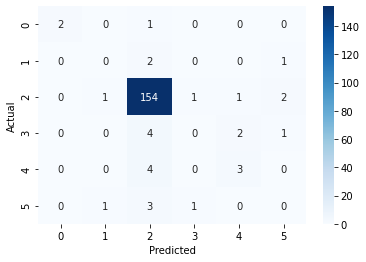

In [172]:
conf_matrix(y_testclass, classpreds)